In this file, we clean up the data scraped from apartments.com.

In the scraper, we didn't include a lot of data validation logic. Plyaing around with it, we see a few issues:

- Some rows have more columns than others. This is from a bug that splits some prices that have commas in them.
- Some rental prices are in a range, such as "$1520 - $1600"
- Some studios are listed as "0" bedrooms, while others are listed as "Studio" bedrooms
- Some rows are missing data

Let's clean all this up, and extract some more useful features from the data.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import csv
from functools import reduce
import re 
from collections import defaultdict

import math

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

import pandas as pd
IN_DIR = '/home/bryce/Projects/Data_Science/Apt_Prices/'
DIR = IN_DIR + 'csvs/'

In [3]:
results_file = IN_DIR + 'apt_scraping_results.csv'

adjusted_lines = []

with open(results_file, 'r') as f:
    for line in f.readlines():
        columns = line.split(';;')
        if len(columns) > 5:
            extra_cols = columns[4:]
            new_col = reduce(lambda s1, s2: s1.strip() + s2.strip(), extra_cols)
            new_cols = columns[:4] + [new_col]
            new_line = ';; '.join(new_cols)
            adjusted_lines.append(new_line + '\n')
            continue
        elif len(columns) <= 2:
            # these are either blank lines or the couple lines where an address wasn't found
            continue
        adjusted_lines.append(line)

adjusted_results_file = IN_DIR + 'apt_scraping_results_cleaned.csv'
with open(adjusted_results_file, 'w') as outfile:
    outfile.writelines(adjusted_lines)

OK, so the number of rows is consistent!

But we can't do regression can't on '$2345' and '2 bds' and whatnot.

So let's clean up the file further.

old file columns:

123 Main St, Charleston, SC, 20401 - Downtown;; $2131;; 2 bd;; 1 ba;; 1,200 sq ft

the new file columns:

123 Main St, Charleston, SC 29401; Downtown; 2; 1; 1200; 2131

In [11]:
df = pd.read_csv(adjusted_results_file, delimiter=';;', names = ['address', 'price', 'beds', 'baths', 'sq_ft'], engine='python')
print(df.columns)

SKIP = -1


# Replaces string 's' that is a range between two numbers, e.g. "1500–1590", with the 
# average of the two numbers, e.g. in this case 1545, as long as the range between
# the two values is less than 'max_range'
# Note that the input is a string and the output is an int.
def replace_range_with_average(s, max_range):
    # get the two values
    m = re.match(r'\D*([0-9]+)–([0-9]+)\D*', s)
    if m is None:
        return SKIP
    (v1, v2) = m.groups(0)
    val1 = int(v1)
    val2 = int(v2)
    diff = val2 - val1
    assert diff >= 0, "Negative value range"
    if diff <= max_range:
        return val1 + math.floor(diff / 2)
    else:
        return SKIP
    
def clean_price(pr_str):
    # Eliminate spaces, commas, and dollar signs.
    pr_s = pr_str.replace(' ', '').replace(',', '')
    pr_s = re.sub(r'\$+', '', pr_s)
    # Now we should either be left with e.g. "1500" or "1500–1580"
    pr_arr = pr_s.split('–')
    if len(pr_arr) > 1:
        avg = replace_range_with_average(pr_s, 80)
        if avg == SKIP:
            print('Unexpected price string or too big a value range: ', pr_str)
        return avg
    
    if not pr_s.isdigit():
        print('Unexpected price string: ', pr_str)
        return SKIP
    price = int(pr_s)
    return price


def get_first_word_as_number(string, expected_num_words):
    arr = string.split()
    if len(arr) != expected_num_words:
        print("Expected " + str(expected_num_words) + " words in this string: ", string)
        return SKIP
    result = re.sub(r',', '', arr[0].strip())
    return result

def clean_sq_ft(s):
    if s is None:
        print("Got None for square footage string")
        return SKIP
    sq_ft_str = s.strip()
    if sq_ft_str == '?':
        return None
    
    # We'll either have e.g. '1200 sq ft' or '1200 - 1250 sq ft'. Handle each case separately.
    sq_ft_arr = sq_ft_str.split('–')
    if len(sq_ft_arr) > 1:
        sq_ft_str = sq_ft_str.replace(' ', '')
        avg = replace_range_with_average(sq_ft_str, 80)
        if avg == SKIP:
            print('Unexpected square footage string or too big a value range: ', s)
        return avg

    sq_ft = get_first_word_as_number(sq_ft_str, 3)
    return int(sq_ft)

def clean_beds(s):
    beds_str = s.strip().lower()
    if beds_str.find('studio') != -1:
        return 0
    else:
        beds = get_first_word_as_number(beds_str, 2)
        return int(beds)

def clean_baths(s):
    baths = get_first_word_as_number(s, 2)
    return float(baths)

addr_and_part_of_town = df['address'].str.split('–', 1, expand=True)
df['address'] = addr_and_part_of_town[0].map(lambda s : s.strip())
df['location'] = addr_and_part_of_town[1].map(lambda s : s.strip() if s else s)  # the if statement handles records with no part of town

df['price'] = df['price'].map(clean_price)
df['beds'] = df['beds'].map(lambda s : clean_beds(s))
df['baths'] = df['baths'].map(lambda s: clean_baths(s))
df['sq_ft'] = df['sq_ft'].map(lambda s : clean_sq_ft(s))

drop_row = (df['price'] == SKIP) | (df['beds'] == SKIP) | (df['baths'] == SKIP) | (df['sq_ft'] == SKIP)
print("We are dropping " + str(drop_row.sum()) + " out of " + str(drop_row.size) + " records.")
df = df[~drop_row]



Index(['address', 'price', 'beds', 'baths', 'sq_ft'], dtype='object')
Unexpected price string:    Call for Rent
Unexpected price string or too big a value range:   $1,760 – $2,261
Unexpected price string or too big a value range:   $1,578 – $2,009
Unexpected price string or too big a value range:   $1,638 – $2,064
Unexpected price string or too big a value range:   $1,446 – $1,768
Unexpected price string or too big a value range:   $1,675 – $2,004
Unexpected price string or too big a value range:   $1,675 – $1,968
Unexpected price string or too big a value range:   $1,610 – $1,901
Unexpected price string:   Call for Rent
Unexpected price string:   Call for Rent
Unexpected price string:   Call for Rent
Unexpected price string:   Call for Rent
Unexpected price string:   Call for Rent
Unexpected price string:   Call for Rent
Unexpected price string:   Call for Rent
Unexpected price string or too big a value range:   $1,748 – $2,187
Unexpected price string:    Call for Rent
Unexpected pric

/tmp/ipykernel_213572/1182042798.py:91: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  addr_and_part_of_town = df['address'].str.split('–', 1, expand=True)


Now we're going to extract a couple more features.

We'll save the zip codes and how many units the building has (i.e., how many rows have the same address as the current row)

In [12]:

# First, we'll add zip code as a new column
zips = df['address'].map(lambda s : s.split()[-1])
df['zip'] = zips


df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3197 entries, 0 to 3261
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   address   3197 non-null   object 
 1   price     3197 non-null   int64  
 2   beds      3197 non-null   int64  
 3   baths     3197 non-null   float64
 4   sq_ft     3181 non-null   float64
 5   location  3197 non-null   object 
 6   zip       3197 non-null   object 
dtypes: float64(2), int64(2), object(3)
memory usage: 199.8+ KB


OK, so we've cleaned the data and added a couple features. Let's change the datatypes from objects to ints and floats

In [13]:
df['price'] = pd.to_numeric(df['price'])
df['beds'] = pd.to_numeric(df['beds'])
df['baths'] = pd.to_numeric(df['baths'])
df['sq_ft'] = pd.to_numeric(df['sq_ft'])


Let's look up some functions for providing summary statistics, bins, range, etc. for each category

In [14]:
df.describe()
one_beds = df.loc[(df.beds == 1)]
#print(one_beds.describe())


# How many one beds are available in each zip code?
piv = one_beds.pivot_table('price', index='zip', aggfunc='count')
piv = piv.rename(columns={'price': 'count'}).sort_values(by='count', ascending=False)
#print(piv)


# There are the most apartments in 29403 (upper peninsula), 29414 (outer west ashley), 29407 (inner west ashley), and 29492 (daniel island)
# Let's just compare one bedrooms across these zip codes

# What is the average square footage and price per apartment in each of those zip code?
zips_map = {'29403': 'Downtown',
               '29407': 'West Ashley - inner',
               '29414': 'West Ashley - outer',
               '29492': 'Daniel Island'}
obs = one_beds[one_beds['zip'].isin(zips_map.keys())]
def map_zips(row):
    return zips_map[row['zip']]

obs['loc'] = obs.apply(map_zips, axis=1)
obs.drop(columns=['location'])

pr_piv = obs.pivot_table(values=['price', 'sq_ft'], index='loc', aggfunc=['mean', 'count'])

print(pr_piv)


                            mean             count      
                           price       sq_ft price sq_ft
loc                                                     
Daniel Island        1924.161616  801.080808    99    99
Downtown             2898.704453  781.130081   247   246
West Ashley - inner  1580.964602  695.734513   113   113
West Ashley - outer  1630.915254  797.262712   118   118


/tmp/ipykernel_213572/3932437879.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs['loc'] = obs.apply(map_zips, axis=1)


Let's plot the square price against square footage for these one bedroom apartments, to see the relationship and the differences across these four parts of town

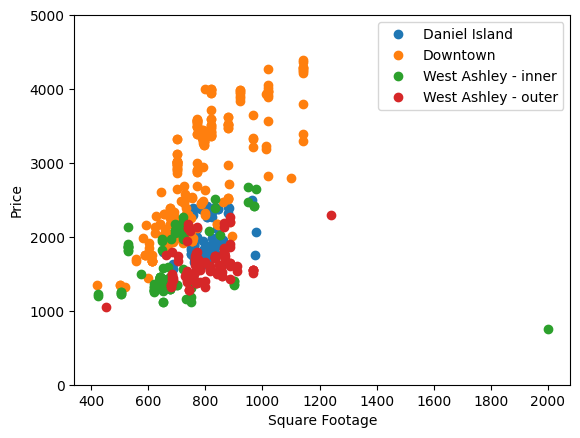

In [15]:
fig, ax = plt.subplots()
groups = obs.groupby('loc')
for loc, group in groups:
    ax.plot(group.sq_ft, group.price, marker='o', linestyle='', label=loc)
ax.legend()
ax.set_xlabel('Square Footage')
ax.set_ylabel('Price')
ax.set_ylim([0,5000])
plt.show()

The above plot seems to show that price per square footage differs in different parts of town. So the zip code categorical variable x square footage would make a good features.

Here's some future data analysis I'd like to do:

- Visualize the prices on a map
- Visualize the square footages on a map

Downtown is interesting, because it is a mixture of old houses and new apartment buildings. Understand the difference in availability between these two types:

- How many 1 bed, 2 bed, 3 bed etc apartments are available for each category
- What square footage range is available in single buildings vs complexes, broken down by number of bedrooms
- Where are apartments of each category located?

In order to map the data, we need each apartment's lat/lng. But we've done some data exploration that shows that a lot of the addresses are "messed up" in some way. Here are the main three ways:

- Duplication: "123 Main Street, 123 Main St, Charleston, SC 29404"
- "Unit"s: "123 Main Street Unit B, Charleston, SC 29404"
- whitespace "             123 Main St, Charleston, SC 29404       "

Let's fix these issues before we try to extract the lat/lngs.

In [16]:
# Here are some functions we use to clean up the addresses.

# This splits the address into three groups. We'll just cut out the 2nd group.
unit_re = r'(.*?)( unit [0-9a-z\.\-\s]+)(,.*)'
unit_comp = re.compile(unit_re)

def remove_unit(addr):
    addr = addr.strip().lower()
    # include groups 1 and 3, but not 2
    cut_addr = unit_comp.sub(r'\1\3', addr)
    cut_addr = cut_addr.title()
    return cut_addr.replace('Sc', 'SC')


name_re = r'[a-z\']+'
word_re = '[a-z]+'
city_re = r'(?:{word} ){{0,2}}{word}'.format(word=word_re)
street_re = '(?:{name} )*{word}'.format(name=name_re, word=word_re)
number_re = '[0-9]+'
spaces_re = r'\s+'
zip_re = '2[0-9]{4}'
address_re = r'{number_re} {street_re}, {city_re}, sc {zip_re}'.format(
    number_re=number_re, street_re=street_re, city_re=city_re, zip_re=zip_re)
search_re = r'.*?({address_re}).*'.format(address_re=address_re)
search_comp = re.compile(search_re)

# Handles the duplication issue.
def extract_address(addr):
    addr = addr.strip().lower()
    m = search_comp.match(addr)
    if m:
        cut_addr = m.groups()[0]
        cut_addr = cut_addr.title()
        return cut_addr.replace('Sc', 'SC')
    else:
        return None

# We do this because technically Daniel Island and Johns Island are in the city of Charleston. The
# lat/lng lookups don't seem to work with these technically inaccurate city names.
def sub_city_names(address):
    if address is None:
        return address
        
    cities_to_sub = {'Daniel Island' : 'Charleston', 'Johns Island' : 'Charleston'}
    for city, sub_city in cities_to_sub.items():
        if city in address:
            return re.sub(city, sub_city, address)
    return address


def clean_address(address):
    if address is None:
        return None
    addr_without_unit = remove_unit(address)
    extracted_addr = extract_address(addr_without_unit)
    addr_city_subbed = sub_city_names(extracted_addr)
    return addr_city_subbed

So now we get those cleaned up addresses:

In [17]:
df['address'] = df.address.map(clean_address)
no_address = df['address'].isna()
df = df[~no_address]

# With the cleaned up addresses, we'll calculate the number of units in that building
address_count = df['address'].value_counts()
units_in_building = df['address'].map(lambda a : address_count[a])
df['units_in_building'] = units_in_building


Now we're also going to read the addresses csv file in as a dataframe. This file contains one line per address, not per unit. It has the address, the property's apartments.com URL, and the text description scraped from apartments.com

In [34]:
address_results_file = IN_DIR + 'addr_scraping_results.csv'
addr_df = pd.read_csv(address_results_file, delimiter=';', names = ['address', 'url', 'title', 'bullets', 'blurb'], engine='python')
addr_df['address'] = addr_df.address.map(clean_address)
no_address = addr_df['address'].isna()
addr_df = addr_df[~no_address]
addr_df['bullets'] = addr_df.bullets.map(lambda s : s.strip())
addr_df = addr_df.drop_duplicates(subset=['address'])

Now let's map these addresses to lat/lng:

In [41]:
# TODO: get a google api key to use for when Nominatim doesn't find the address.


import geopy
from geopy.exc import GeocoderUnavailable
from geopy.geocoders import Nominatim
import time


geolocator = Nominatim(user_agent="charleston_apt_prices")
def get_latlng(address):
    try:
        location = geolocator.geocode(address)
        if location:
            latlng = (location.latitude, location.longitude)
            print("Address " + address + " mapped to: ", latlng)
            return latlng
        else:
            print("Couldn't map address: ", address)
            return None
    except GeocoderUnavailable as e:
        time.sleep(10)
        return None


/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.14) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [39]:
# This commented code does the following:
# 1) reads the previous addr_df data, to get the previously mapped latlngs
# 2) merges that with the current addr_df
# 3) separates the addresses missing latlng after the merge into addr_df_missing_latlng
# 4) calls get_latlng on those addresses
# 5) merges those results into combined_addr_df


# addr_df_old = pd.read_csv(DIR + 'pd_address_info.csv', sep=';', usecols=['address', 'latlng']).drop_duplicates()
# addr_df_latlng = addr_df.merge(addr_df_old, on='address', how='left')

# addr_df_missing_latlng = addr_df_latlng.loc[addr_df_latlng.latlng.isna()]

# addr_df_missing_latlng['latlng'] = addr_df_missing_latlng.address.map(get_latlng)
# combined_addr_df = addr_df_latlng.merge(addr_df_missing_latlng[['address', 'latlng']], on='address', how='left')
# missing_original_latlng = combined_addr_df.latlng_x.isna()
# combined_addr_df.latlng_x.loc[missing_original_latlng] = combined_addr_df.latlng_y 
# combined_addr_df['latlng'] = combined_addr_df.latlng_x 
# combined_addr_df.drop(columns=['latlng_x', 'latlng_y'], inplace=True)


We've looked up the latlng of the addresses missing latlngs by hand. So here we merge these into the looked up results. But we need to clean this code to eliminate this step.

In [69]:
# missing_addresses_file = DIR + 'google_latlngs.csv'
# google_latlng_df = pd.read_csv(missing_addresses_file, sep=';')
# merged = pd.merge(combined_addr_df, google_latlng_df, on='address', how='left')
# merged.google_latlng = merged.google_latlng.map(lambda s : '(' + str(s) + ')')
# na_indices = merged.latlng.isna()
# merged['latlng'] = np.where(na_indices, merged['google_latlng'], merged['latlng'])
# merged.head()
# merged.drop(columns='google_latlng', inplace=True)
# still_missing_latlng = merged.latlng == '(nan)'
# addresses_missing_latlng = merged.loc[still_missing_latlng][['address']]
# addresses_missing_latlng.to_csv(DIR + 'march8/addresses_missing_latlng.csv', index=False)
# merged = merged.loc[~still_missing_latlng]

# new_addr_df = pd.merge(merged, addr_df, on='address', how='inner')
# print(new_addr_df.head())
# print(new_addr_df.shape)



# output = DIR + 'march8/pd_address_info.csv'
# merged.to_csv(output, sep=';', index=False)

In [70]:
# output = DIR + 'march8/pd_apt_info.csv'
# df.to_csv(output, sep=';', index=False)